# analyze the result of 3DCNN_prof

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams["figure.dpi"] = 150
sns.set(style='darkgrid')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display

In [2]:
# function for performance evaluation 
def get_loss(target_df, label_name, column_name):
    try:
        loss = target_df[label_name].max() - target_df[label_name][target_df[column_name].idxmax()]
    except TypeError as e:
        loss = None
    return loss

def get_whole_loss(df, label_name: str, column_list: list):
    loss_list = [get_loss(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' Loss':loss_list}, index=column_list)

def get_mae(df, label_name, column_name):
    df = df.dropna(subset=[column_name])
    try:
        mae = mean_absolute_error(df[label_name], df[column_name])
    except ValueError as e:
        mae = None
    return mae

def get_whole_mae(df, label_name: str, column_list: list):
    mae_list = [get_mae(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' MAE':mae_list}, index=column_list)

def get_mse(df, label_name, column_name):
    df = df.dropna(subset=[column_name])
    try:
        mse = mean_squared_error(df[label_name], df[column_name])
    except ValueError as e:
        mse = None
    return mse

def get_whole_mse(df, label_name: str, column_list: list):
    mse_list = [get_mse(df, label_name, column) for column in column_list]
    return pd.DataFrame({label_name + ' MSE':mse_list}, index=column_list)

def eval(df, columns, label_name='GDT_TS', threshold=0):
    metrics_array = []
    df = df.groupby('Target').filter(lambda x: x[label_name].max() >= threshold)
    if df[label_name].max() > 1:
        df[label_name] /= 100
    group = df.groupby('Target')
    pearson = group.corr()[label_name].loc[:, columns].rename(label_name + ' Pearson')
    spearman = group.corr(method='spearman')[label_name].loc[:, columns].rename(label_name + ' Spearman')
    loss = group.apply(lambda x: get_whole_loss(x, label_name, columns)) * 100
    mae = group.apply(lambda x: get_whole_mae(x, label_name, columns))
    mse = group.apply(lambda x: get_whole_mse(x, label_name, columns))
    performance_df = pd.concat([pearson, spearman, loss, mae, mse], axis=1).reset_index().rename(columns={'level_1': 'Group'})
    print(len(group))
    return performance_df

In [3]:
# function for visualization
def scatter(df, x='GDT_TS', y='Proposed', col_wrap=4):
    g = sns.relplot(data=df, kind='scatter', x=x, y=y, col='Target', col_wrap=col_wrap)
    g.set(xlim=(0, 100), ylim=(0, 1))
    plt.subplots_adjust(wspace=0.1)

## read mqa score

In [12]:
df = pd.read_csv('../download/data/casp14_stage2.csv', index_col=0)
sato_df = pd.read_csv('../data/casp14_sato.csv', index_col=0)
df = pd.merge(df, sato_df, left_index=True, right_index=True, how='outer')
df = df.dropna(subset=['GDT_TS'])

In [13]:
# filter targets not included in the mqa results table (T1027, T1088) and not define domain classification (T1048, T1062, T1072s1, T1098)
fil_target = ['T1027', 'T1088'] + ['T1048', 'T1062', 'T1072s1', 'T1098']
df_fil = df.groupby('Target').filter(lambda x: x.name not in fil_target)

In [15]:
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9894 entries, T1024TS013_1 to T1101TS487_5
Data columns (total 69 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   3DCNN_prof           9894 non-null   float64
 1   ProQ3D               9894 non-null   float64
 2   GraphQA              9144 non-null   float64
 3   angleQA              9894 non-null   float64
 4   ProQ2                9466 non-null   float64
 5   DAVIS-EMAconsensus   9894 non-null   float64
 6   BAKER-ROSETTASERVER  9891 non-null   float64
 7   BAKER-experimental   9891 non-null   float64
 8   P3De                 9893 non-null   float64
 9   ModFOLD8             9893 non-null   float64
 10  tFold-IDT            9894 non-null   float64
 11  VoroCNN-GDT          9887 non-null   float64
 12  VoroCNN-GEMME        9887 non-null   float64
 13  DeepPotential        9738 non-null   float64
 14  Ornate               9893 non-null   float64
 15  SBROD                989

In [14]:
dom_cla_df = pd.read_csv('../download/data/casp14_domain_definitions_and_classifications_fixed.csv', index_col=0)
# delete duplicated target (multidomain)
dom_cla_df = dom_cla_df.drop_duplicates(keep='first', subset='Target')
dom_cla_df

,Target,Residues,Type,Domains,Residues in domain,Classification,PDB,Domain
#,,,,,,,,
1,T1024,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
3,T1025,268,Server only,T1025-D1: 12-268,257,TBM-easy,6uv6,SingleDomain
4,T1026,172,All groups,T1026-D1: 27-172,146,TBM-hard,6s44,SingleDomain
5,T1027,168,All groups,"T1027-D1: 8-18,34-81,95-134",99,FM,-,SingleDomain
6,T1028,316,Server only,T1028-D1: 16-307,292,TBM-easy,-,SingleDomain
...,...,...,...,...,...,...,...,...
99,T1095,665,All groups,T1095-D1: 1-649,649,TBM-hard,-,SingleDomain
100,T1096,464,All groups,T1096-D0,464,FM,-,MultiDomain
102,T1099,262,All groups,T1099-D1: 11-188,178,TBM-hard,6ygh,SingleDomain


### performance evaluation of 3dcnn_prof

In [16]:
single_model_list = ['3DCNN_prof', 'ProQ3D', 'GraphQA', 'angleQA', 'ProQ2',
       'DAVIS-EMAconsensus', 'BAKER-ROSETTASERVER', 'BAKER-experimental',
       'P3De', 'ModFOLD8', 'tFold-IDT', 'VoroCNN-GDT', 'VoroCNN-GEMME',
       'DeepPotential', 'Ornate', 'SBROD', 'LDDT', 'Sato-3DCNN', 'without_ss_rsa']

In [17]:
eval_df = eval(df_fil, columns=single_model_list, threshold=40)
eval_df.groupby('Group').mean().reset_index()

58


,Group,GDT_TS Pearson,GDT_TS Spearman,GDT_TS Loss,GDT_TS MAE,GDT_TS MSE
0,3DCNN_prof,0.598,0.560,10.480,0.149,0.034
1,BAKER-ROSETTASERVER,0.662,0.613,8.332,0.117,0.023
2,BAKER-experimental,0.623,0.589,8.378,0.121,0.025
3,DAVIS-EMAconsensus,0.764,0.696,8.998,0.070,0.011
4,DeepPotential,0.590,0.498,11.856,0.117,0.027
5,GraphQA,0.521,0.482,9.841,0.135,0.030
6,LDDT,0.780,0.784,2.002,0.099,0.014
7,ModFOLD8,0.649,0.602,8.496,0.140,0.032
8,Ornate,0.550,0.515,12.231,0.158,0.036
9,P3De,0.560,0.516,10.645,0.120,0.023


In [18]:
ceval_df = pd.merge(eval_df, dom_cla_df, on='Target', how='inner')
ceval_df

,Target,Group,GDT_TS Pearson,GDT_TS Spearman,GDT_TS Loss,GDT_TS MAE,GDT_TS MSE,Residues,Type,Domains,Residues in domain,Classification,PDB,Domain
0,T1024,3DCNN_prof,0.631,0.628,3.645,0.090,0.010,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
1,T1024,ProQ3D,0.753,0.648,3.772,0.087,0.010,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
2,T1024,GraphQA,0.738,0.573,4.412,0.120,0.016,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
3,T1024,angleQA,0.738,0.738,5.115,0.071,0.007,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
4,T1024,ProQ2,0.660,0.597,3.772,0.082,0.009,408,All groups,T1024-D0,408,TBM-easy,6t1z,MultiDomain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,T1101,Ornate,0.235,0.249,1.179,0.047,0.003,318,All groups,T1101-D0: 12-318,307,TBM-easy,-,MultiDomain
1098,T1101,SBROD,0.291,0.301,3.452,0.203,0.047,318,All groups,T1101-D0: 12-318,307,TBM-easy,-,MultiDomain
1099,T1101,LDDT,0.607,0.583,3.115,0.114,0.015,318,All groups,T1101-D0: 12-318,307,TBM-easy,-,MultiDomain
1100,T1101,Sato-3DCNN,0.283,0.271,6.734,0.131,0.021,318,All groups,T1101-D0: 12-318,307,TBM-easy,-,MultiDomain


## read evolutional information reliability

In [19]:
evol_df = pd.read_csv('../data/casp14_evolutional_info.csv', index_col=0)

In [20]:
cdf = pd.merge(ceval_df, evol_df, on='Target', how='outer')
cdf

,Target,Group,GDT_TS Pearson,GDT_TS Spearman,GDT_TS Loss,GDT_TS MAE,GDT_TS MSE,Residues,Type,Domains,Residues in domain,Classification,PDB,Domain,ss_acc,rsa_mae,rsa_r2,hit_num,mean_evalue
0,T1024,3DCNN_prof,0.631,0.628,3.645,0.090,0.010,408.000,All groups,T1024-D0,408.000,TBM-easy,6t1z,MultiDomain,0.908,18.201,0.003,500,0.000
1,T1024,ProQ3D,0.753,0.648,3.772,0.087,0.010,408.000,All groups,T1024-D0,408.000,TBM-easy,6t1z,MultiDomain,0.908,18.201,0.003,500,0.000
2,T1024,GraphQA,0.738,0.573,4.412,0.120,0.016,408.000,All groups,T1024-D0,408.000,TBM-easy,6t1z,MultiDomain,0.908,18.201,0.003,500,0.000
3,T1024,angleQA,0.738,0.738,5.115,0.071,0.007,408.000,All groups,T1024-D0,408.000,TBM-easy,6t1z,MultiDomain,0.908,18.201,0.003,500,0.000
4,T1024,ProQ2,0.660,0.597,3.772,0.082,0.009,408.000,All groups,T1024-D0,408.000,TBM-easy,6t1z,MultiDomain,0.908,18.201,0.003,500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1122,T1088,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,nan,nan,nan,500,0.000
1123,T1091,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,nan,nan,nan,500,0.000
1124,T1093,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,nan,nan,nan,500,0.000
1125,T1096,NaN,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,NaN,nan,nan,nan,8,0.080


In [21]:
proposed_df = cdf.query('Group == "3DCNN_prof"')

In [22]:
def scatter_plot_each_reliability(x, df):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(12, 8))
    y = 'ss_acc'
    sns.scatterplot(data=df, x=x, y=y, ax=axes[0, 0])
    y = 'rsa_mae'
    sns.scatterplot(data=df, x=x, y=y, ax=axes[0, 1])
    y = 'rsa_r2'
    sns.scatterplot(data=df, x=x, y=y, ax=axes[0, 2])
    y = 'hit_num'
    sns.scatterplot(data=df, x=x, y=y, ax=axes[1, 0])
    y = 'mean_evalue'
    sns.scatterplot(data=df, x=x, y=y, ax=axes[1, 1])
    fig.tight_layout()

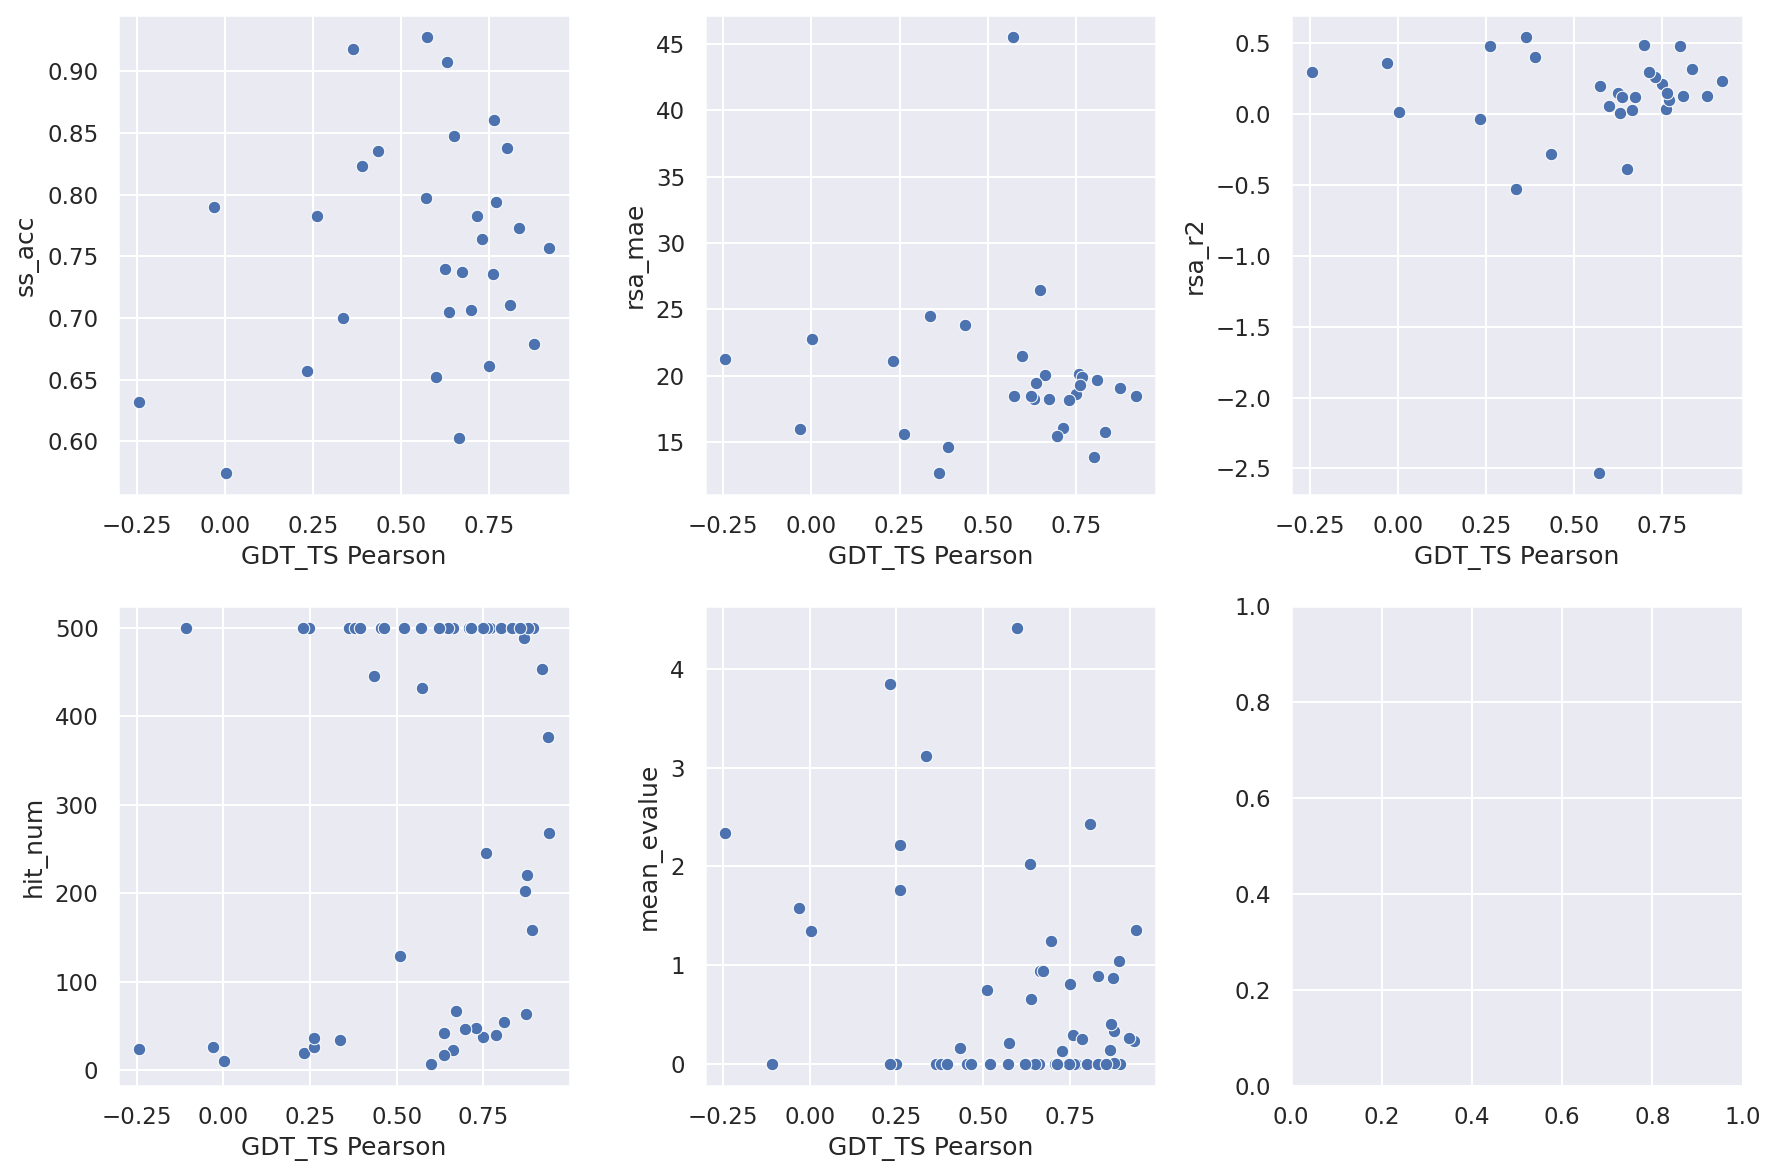

In [23]:
scatter_plot_each_reliability(x='GDT_TS Pearson', df=proposed_df)
plt.savefig('../data/plot/casp14_scatter_gdtts_pearson_evol_reliability.png')

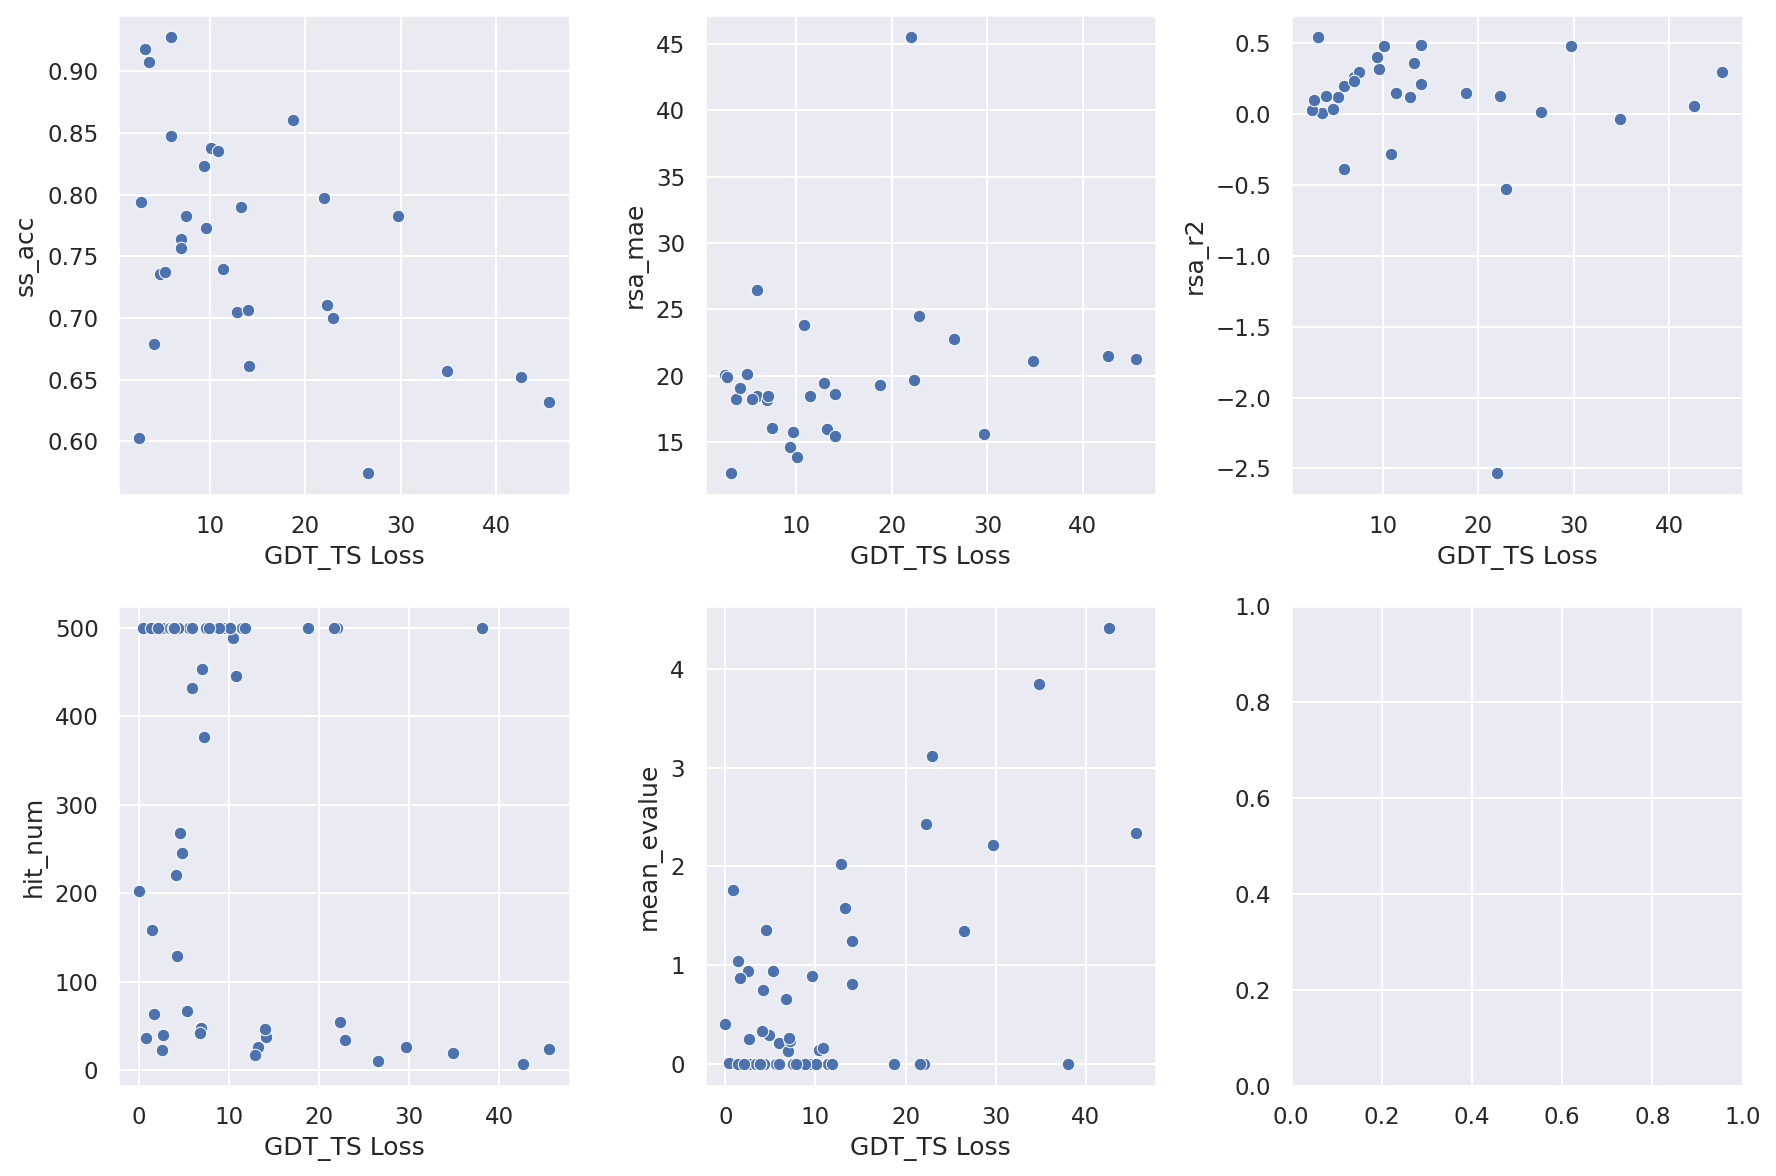

In [24]:
scatter_plot_each_reliability(x='GDT_TS Loss', df=proposed_df)
plt.savefig('../data/plot/casp14_scatter_gdtts_loss_evol_reliability.png')

In [25]:
proposed_df.sort_values('GDT_TS Pearson')

,Target,Group,GDT_TS Pearson,GDT_TS Spearman,GDT_TS Loss,GDT_TS MAE,GDT_TS MSE,Residues,Type,Domains,Residues in domain,Classification,PDB,Domain,ss_acc,rsa_mae,rsa_r2,hit_num,mean_evalue
114,T1031,3DCNN_prof,-0.244,-0.186,45.527,0.203,0.063,95.000,All groups,T1031-D1: 1-95,95.000,FM,6vr4,SingleDomain,0.632,21.275,0.291,24,2.341
988,T1092,3DCNN_prof,-0.108,-0.159,38.029,0.109,0.016,426.000,All groups,T1092-D0,426.000,TBM-hard,-,MultiDomain,nan,nan,nan,500,0.000
152,T1033,3DCNN_prof,-0.031,0.048,13.250,0.105,0.015,100.000,All groups,T1033-D1: 1-100,100.000,FM,6vr4,SingleDomain,0.790,15.997,0.355,26,1.576
323,T1043,3DCNN_prof,0.002,0.270,26.520,0.070,0.010,148.000,All groups,T1043-D1: 1-148,148.000,FM,6vr4,SingleDomain,0.574,22.718,0.012,11,1.345
1026,T1095,3DCNN_prof,0.230,0.228,3.858,0.094,0.011,665.000,All groups,T1095-D1: 1-649,649.000,TBM-hard,-,SingleDomain,nan,nan,nan,500,0.000
190,T1035,3DCNN_prof,0.232,0.203,34.804,0.228,0.077,102.000,All groups,T1035-D1: 1-102,102.000,FM/TBM,6vr4,SingleDomain,0.657,21.084,-0.035,20,3.846
950,T1089,3DCNN_prof,0.248,0.294,7.825,0.078,0.008,404.000,All groups,T1089-D1: 28-404,377.000,TBM-easy,-,SingleDomain,nan,nan,nan,500,0.000
931,T1087,3DCNN_prof,0.261,0.452,0.807,0.104,0.018,186.000,All groups,T1087-D1: 1-93,93.000,TBM-hard,-,SingleDomain,nan,nan,nan,36,1.765
247,T1039,3DCNN_prof,0.261,0.385,29.658,0.120,0.019,161.000,All groups,T1039-D1: 1-161,161.000,FM,6vr4,SingleDomain,0.783,15.563,0.477,26,2.212
266,T1040,3DCNN_prof,0.336,0.348,22.885,0.078,0.009,130.000,All groups,T1040-D1: 1-130,130.000,FM,6vr4,SingleDomain,0.700,24.521,-0.531,34,3.114


In [17]:
proposed_df['ss_acc'].mean()

0.7563762110041427

In [18]:
proposed_df['rsa_mae'].mean()

19.7607084274292

In [19]:
proposed_df['rsa_r2'].mean()

0.058833942192516316

In [21]:
len(proposed_df.query('not rsa_r2.isnull()'))

30

## without evolutional information

In [27]:
sato_3dcnn_df = cdf.query('Group == "Sato-3DCNN"')

In [30]:
compare_methods = ['3DCNN_prof', 'Sato-3DCNN', 'without_ss_rsa']
compare_df = cdf.query('Group in @compare_methods')

In [43]:
def scatter_plot_each_reliability_compare(x, df):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(16, 10))
    hue = 'Group'
    y = 'ss_acc'
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=axes[0, 0])
    y = 'rsa_mae'
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=axes[0, 1])
    y = 'rsa_r2'
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=axes[0, 2])
    y = 'hit_num'
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=axes[1, 0])
    y = 'mean_evalue'
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=axes[1, 1])
    fig.tight_layout()

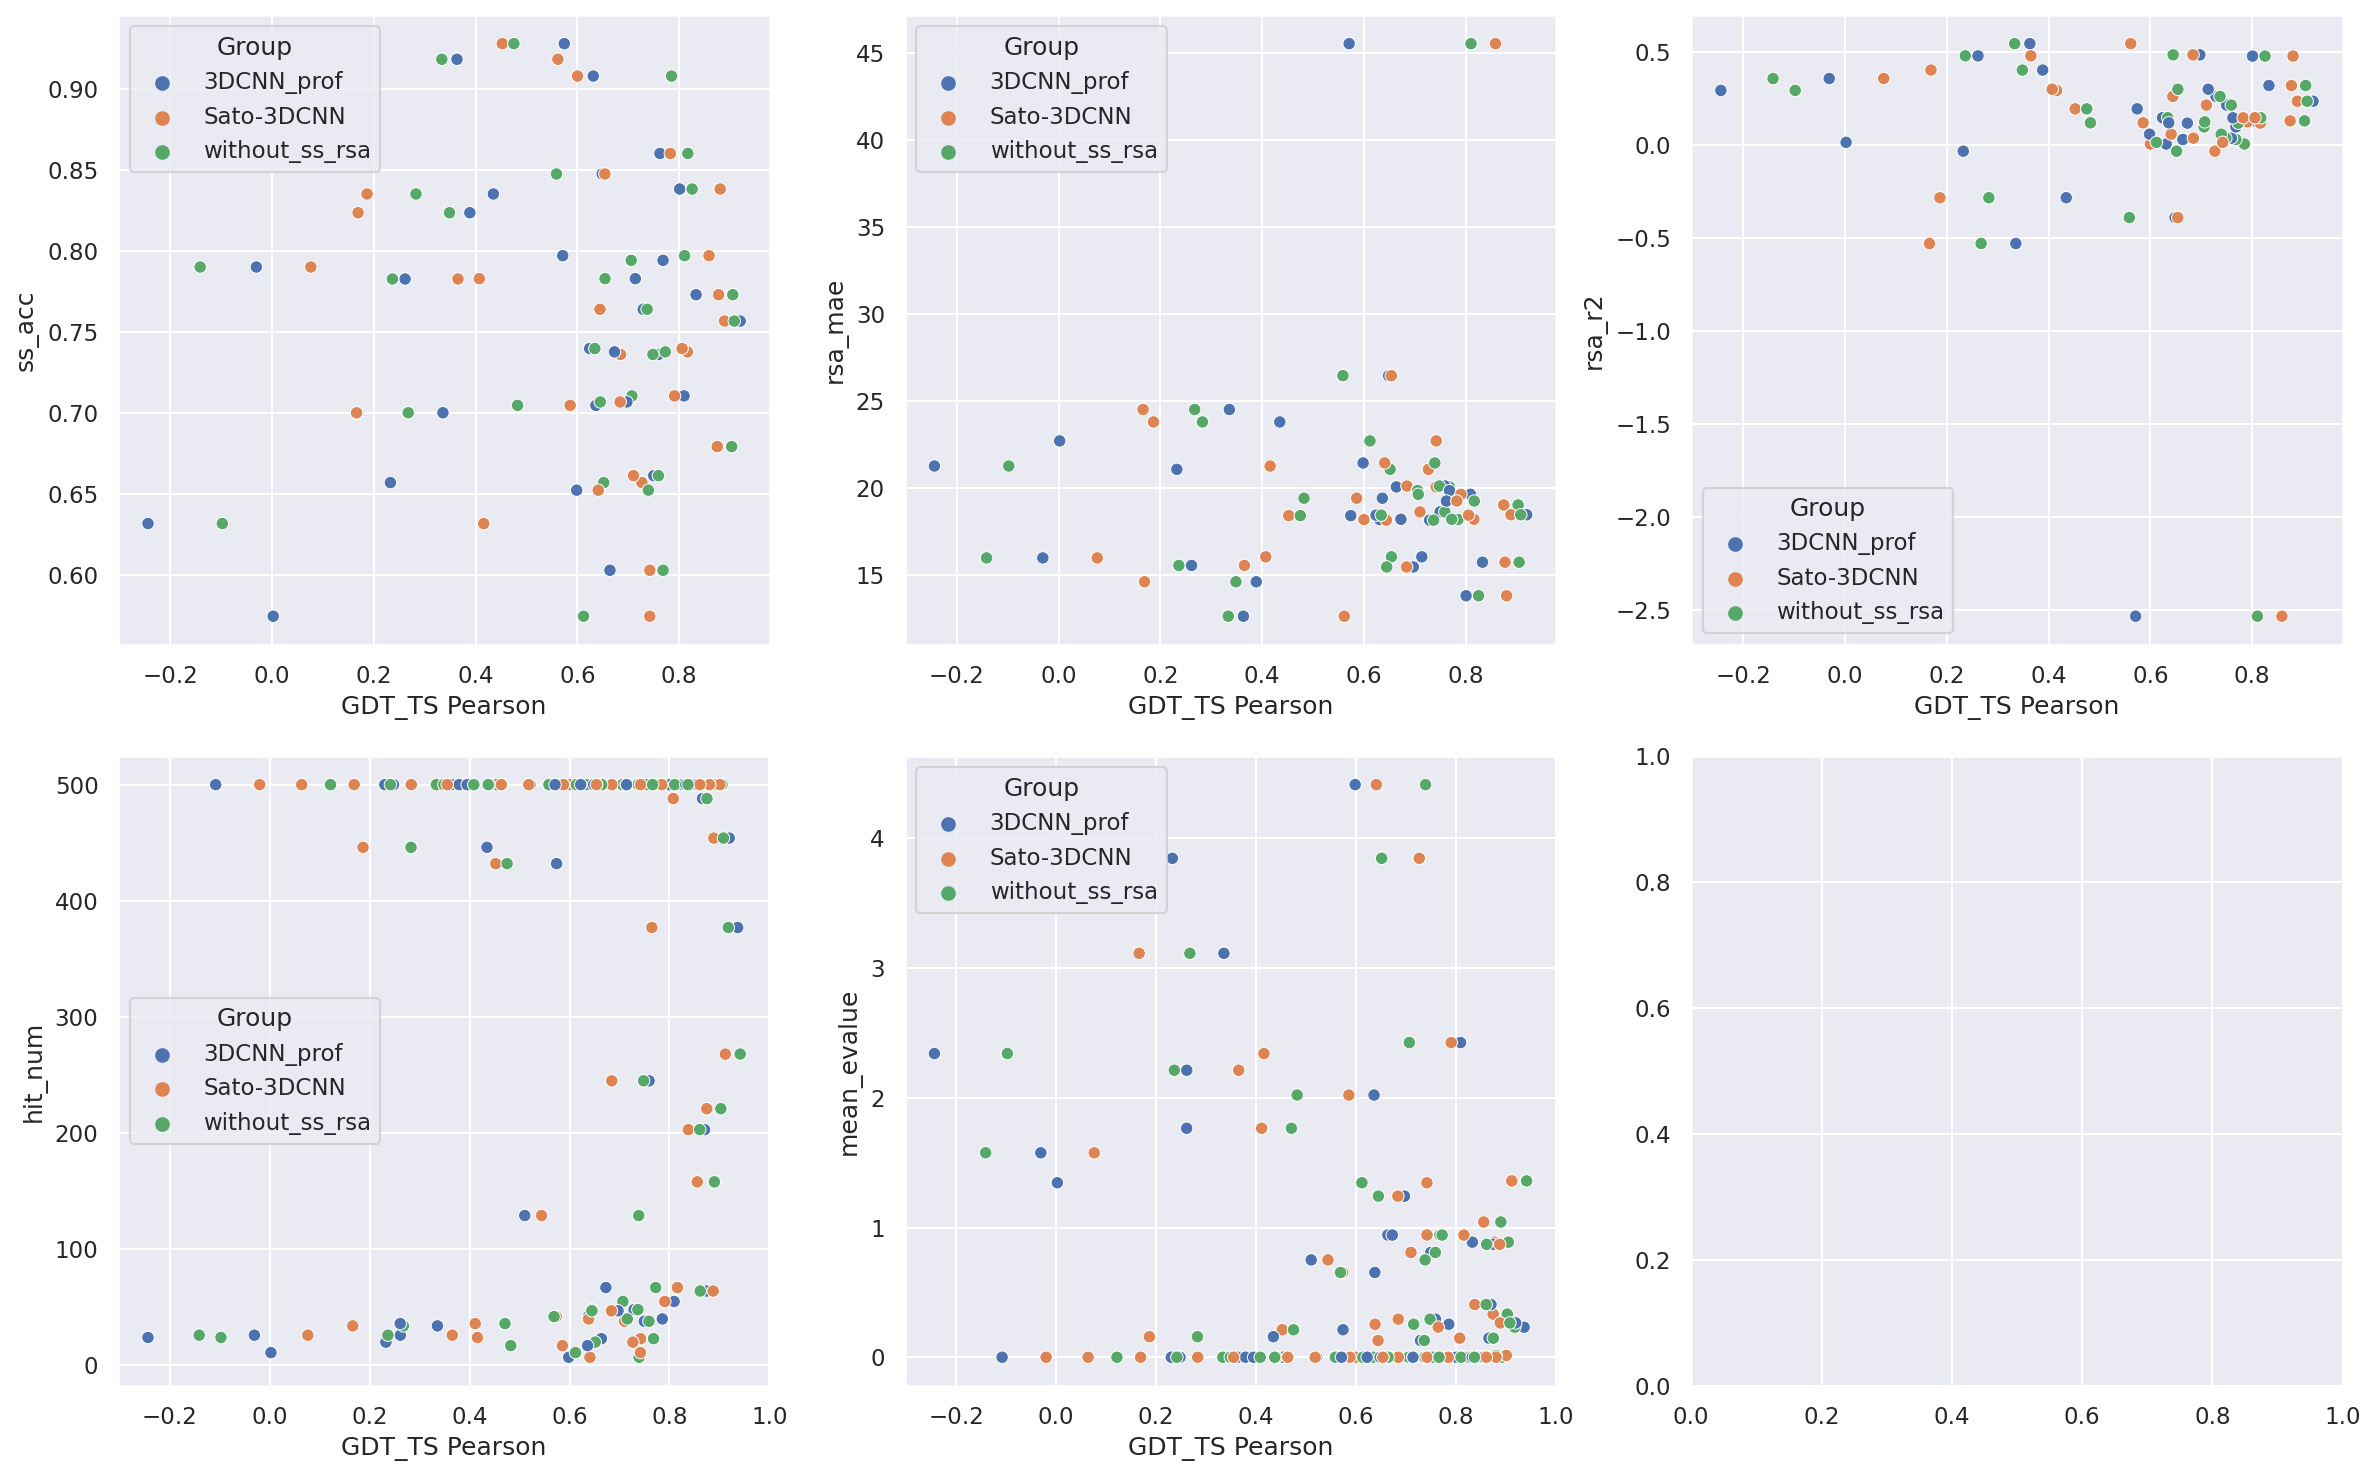

In [80]:
scatter_plot_each_reliability_compare(x='GDT_TS Pearson', df=compare_df)
plt.savefig('../data/plot/casp14_scatter_gdtts_pearson_evol_reliability_compare.png')

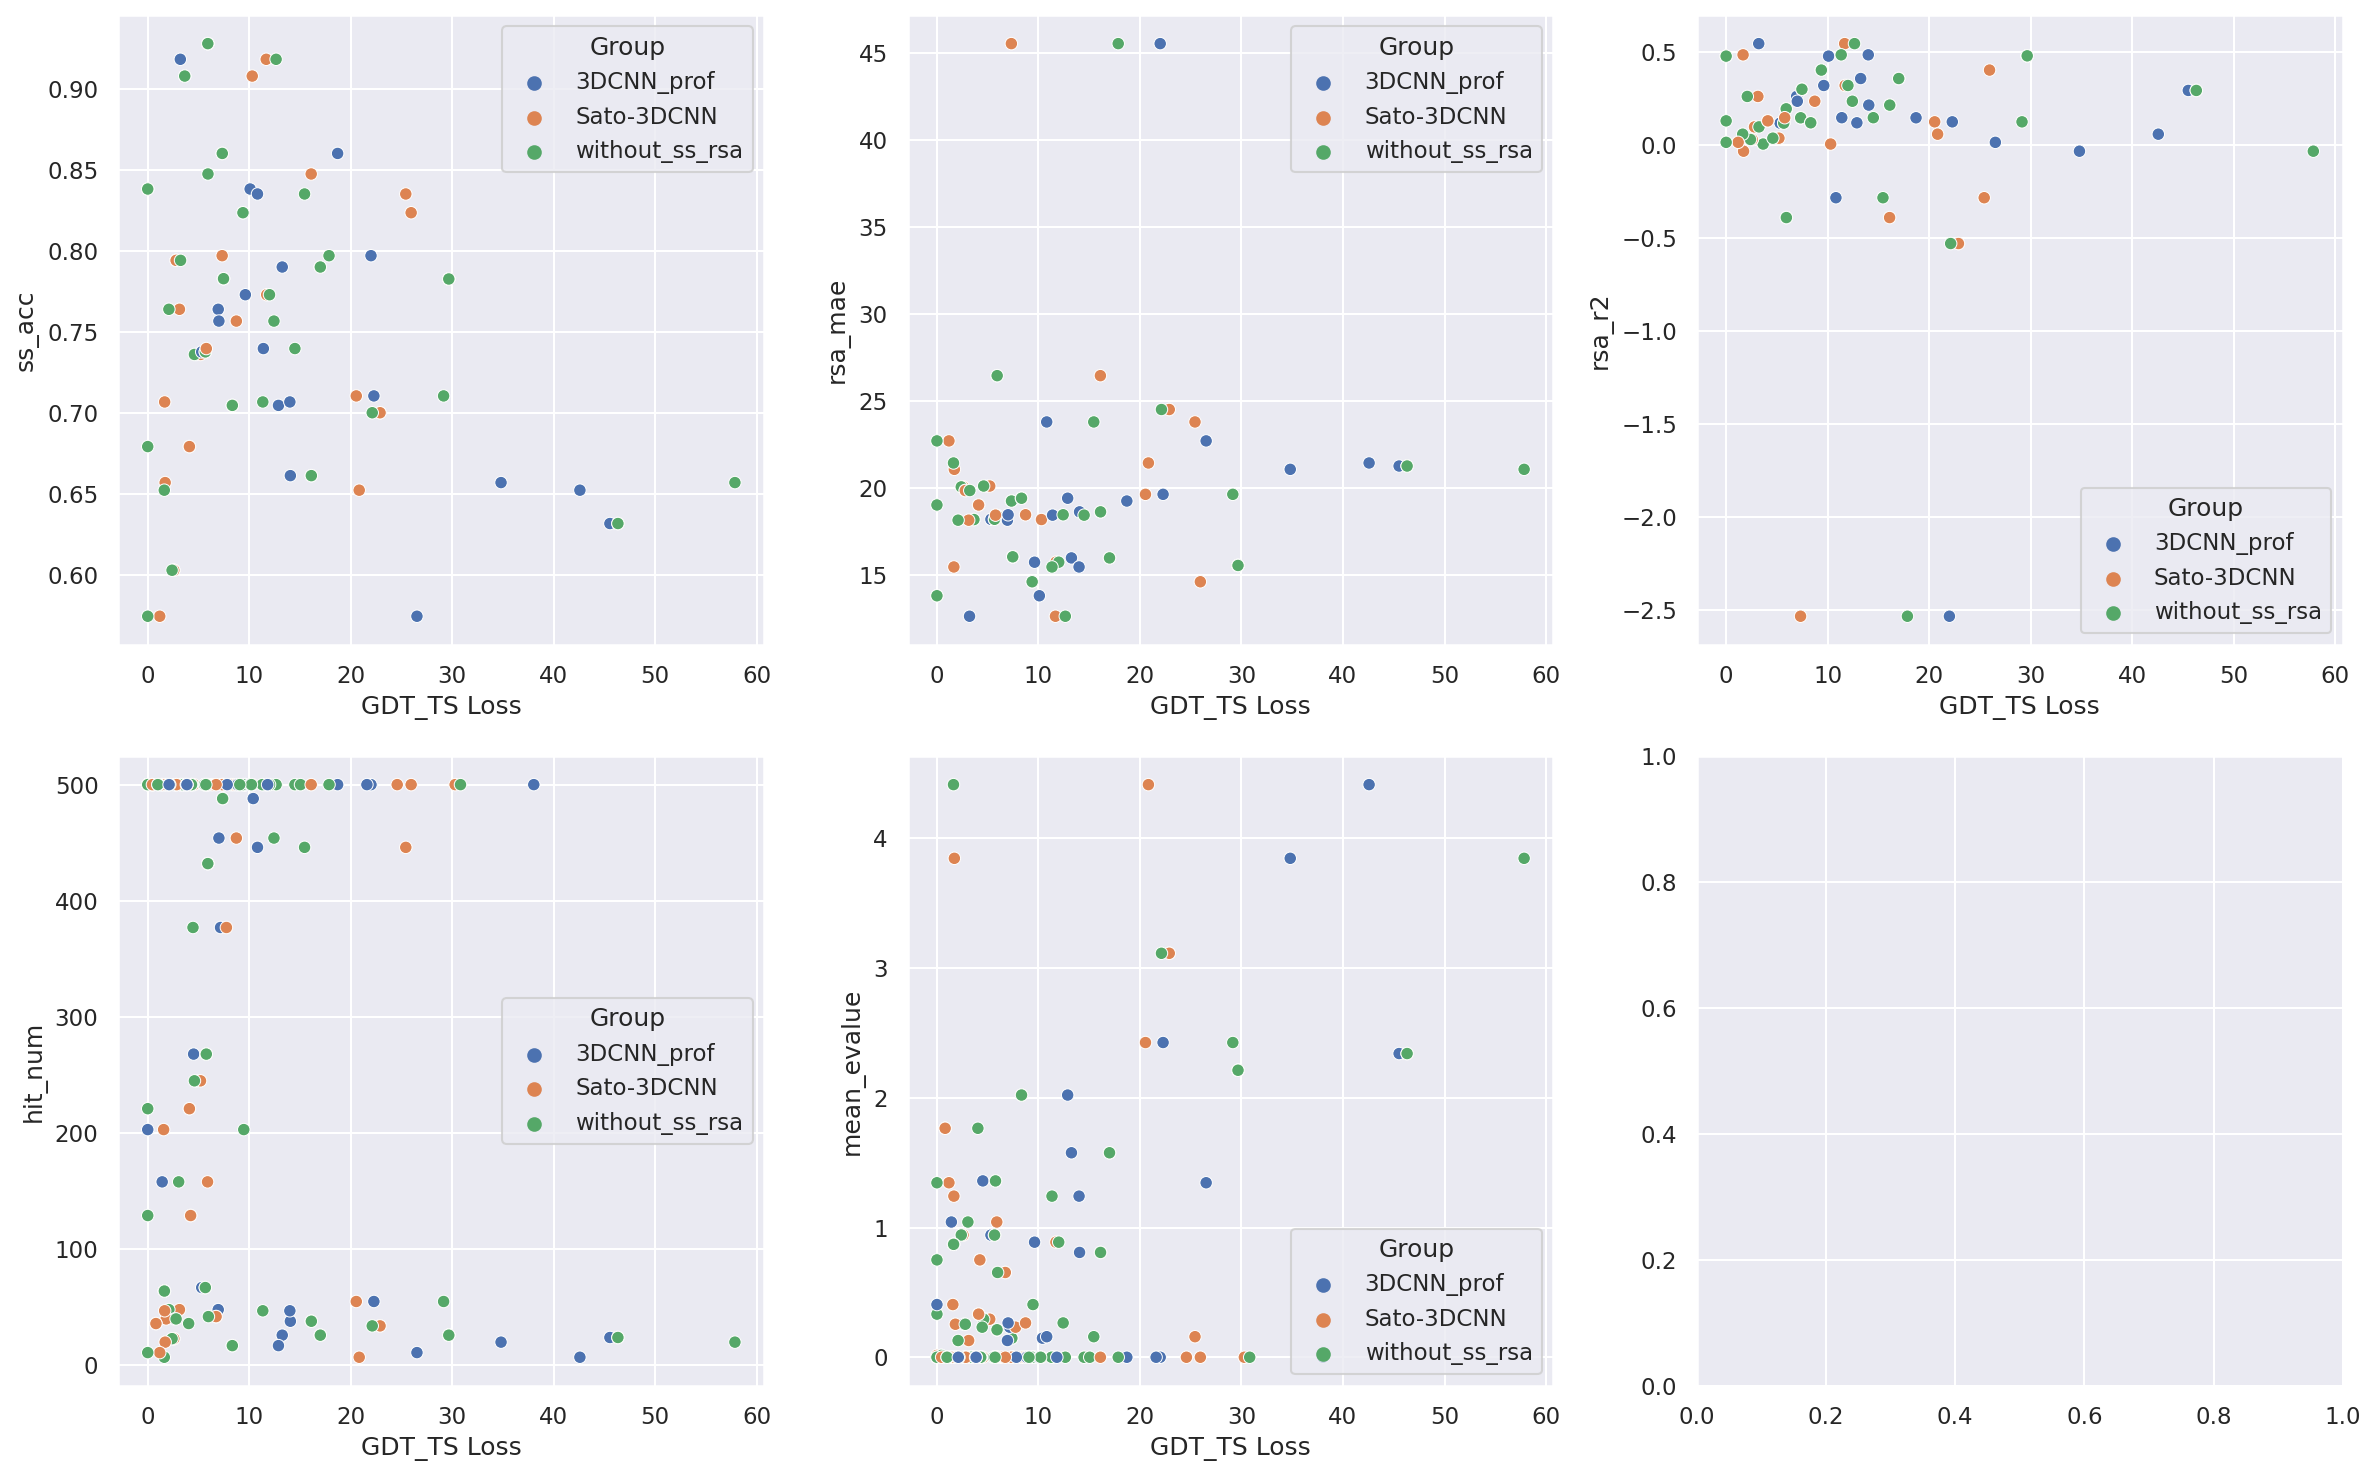

In [81]:
scatter_plot_each_reliability_compare(x='GDT_TS Loss', df=compare_df)
plt.savefig('../data/plot/casp14_scatter_gdtts_loss_evol_reliability_compare.png')

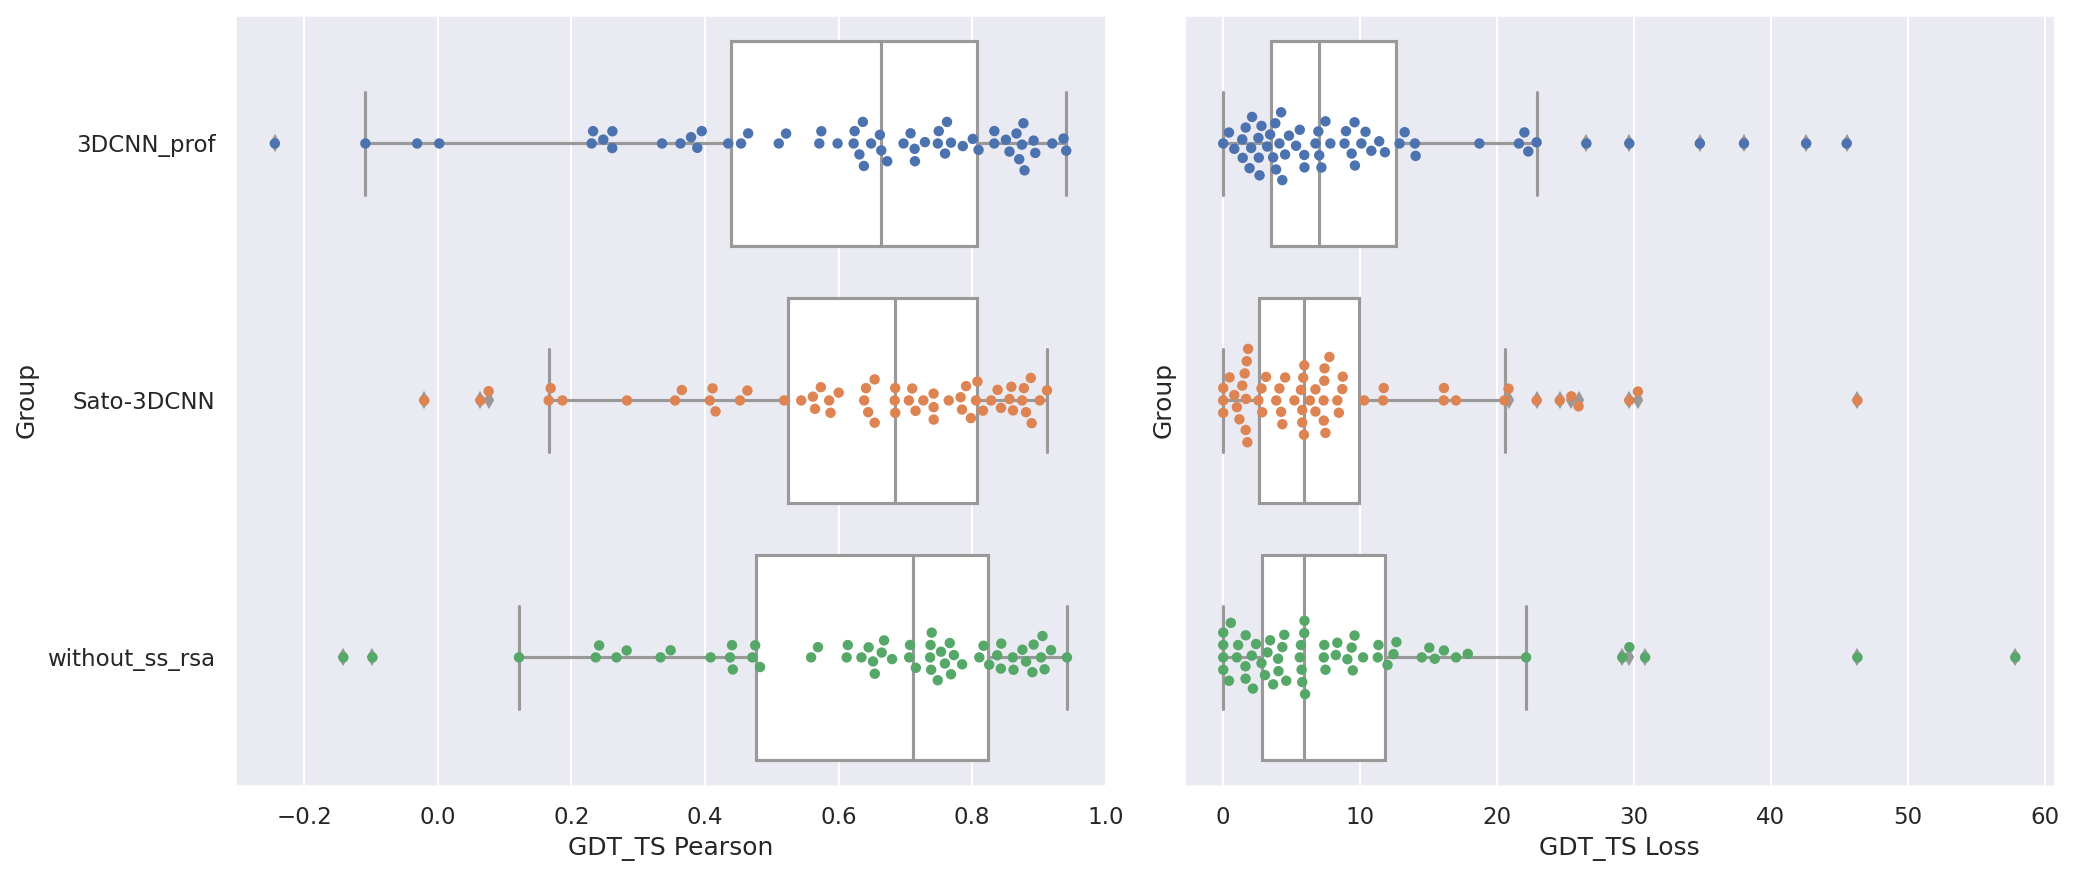

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=(14,6))
x = 'GDT_TS Pearson'
sns.boxplot(data=compare_df, x=x, y='Group', color='white', ax=axes[0])
sns.swarmplot(data=compare_df, x=x, y='Group', ax=axes[0])
x = 'GDT_TS Loss'
sns.boxplot(data=compare_df, x=x, y='Group', color='white', ax=axes[1])
sns.swarmplot(data=compare_df, x=x, y='Group', ax=axes[1])
plt.tight_layout()
plt.savefig('../data/plot/casp14_proposed_pearson_loss_boxplot_compare.png')

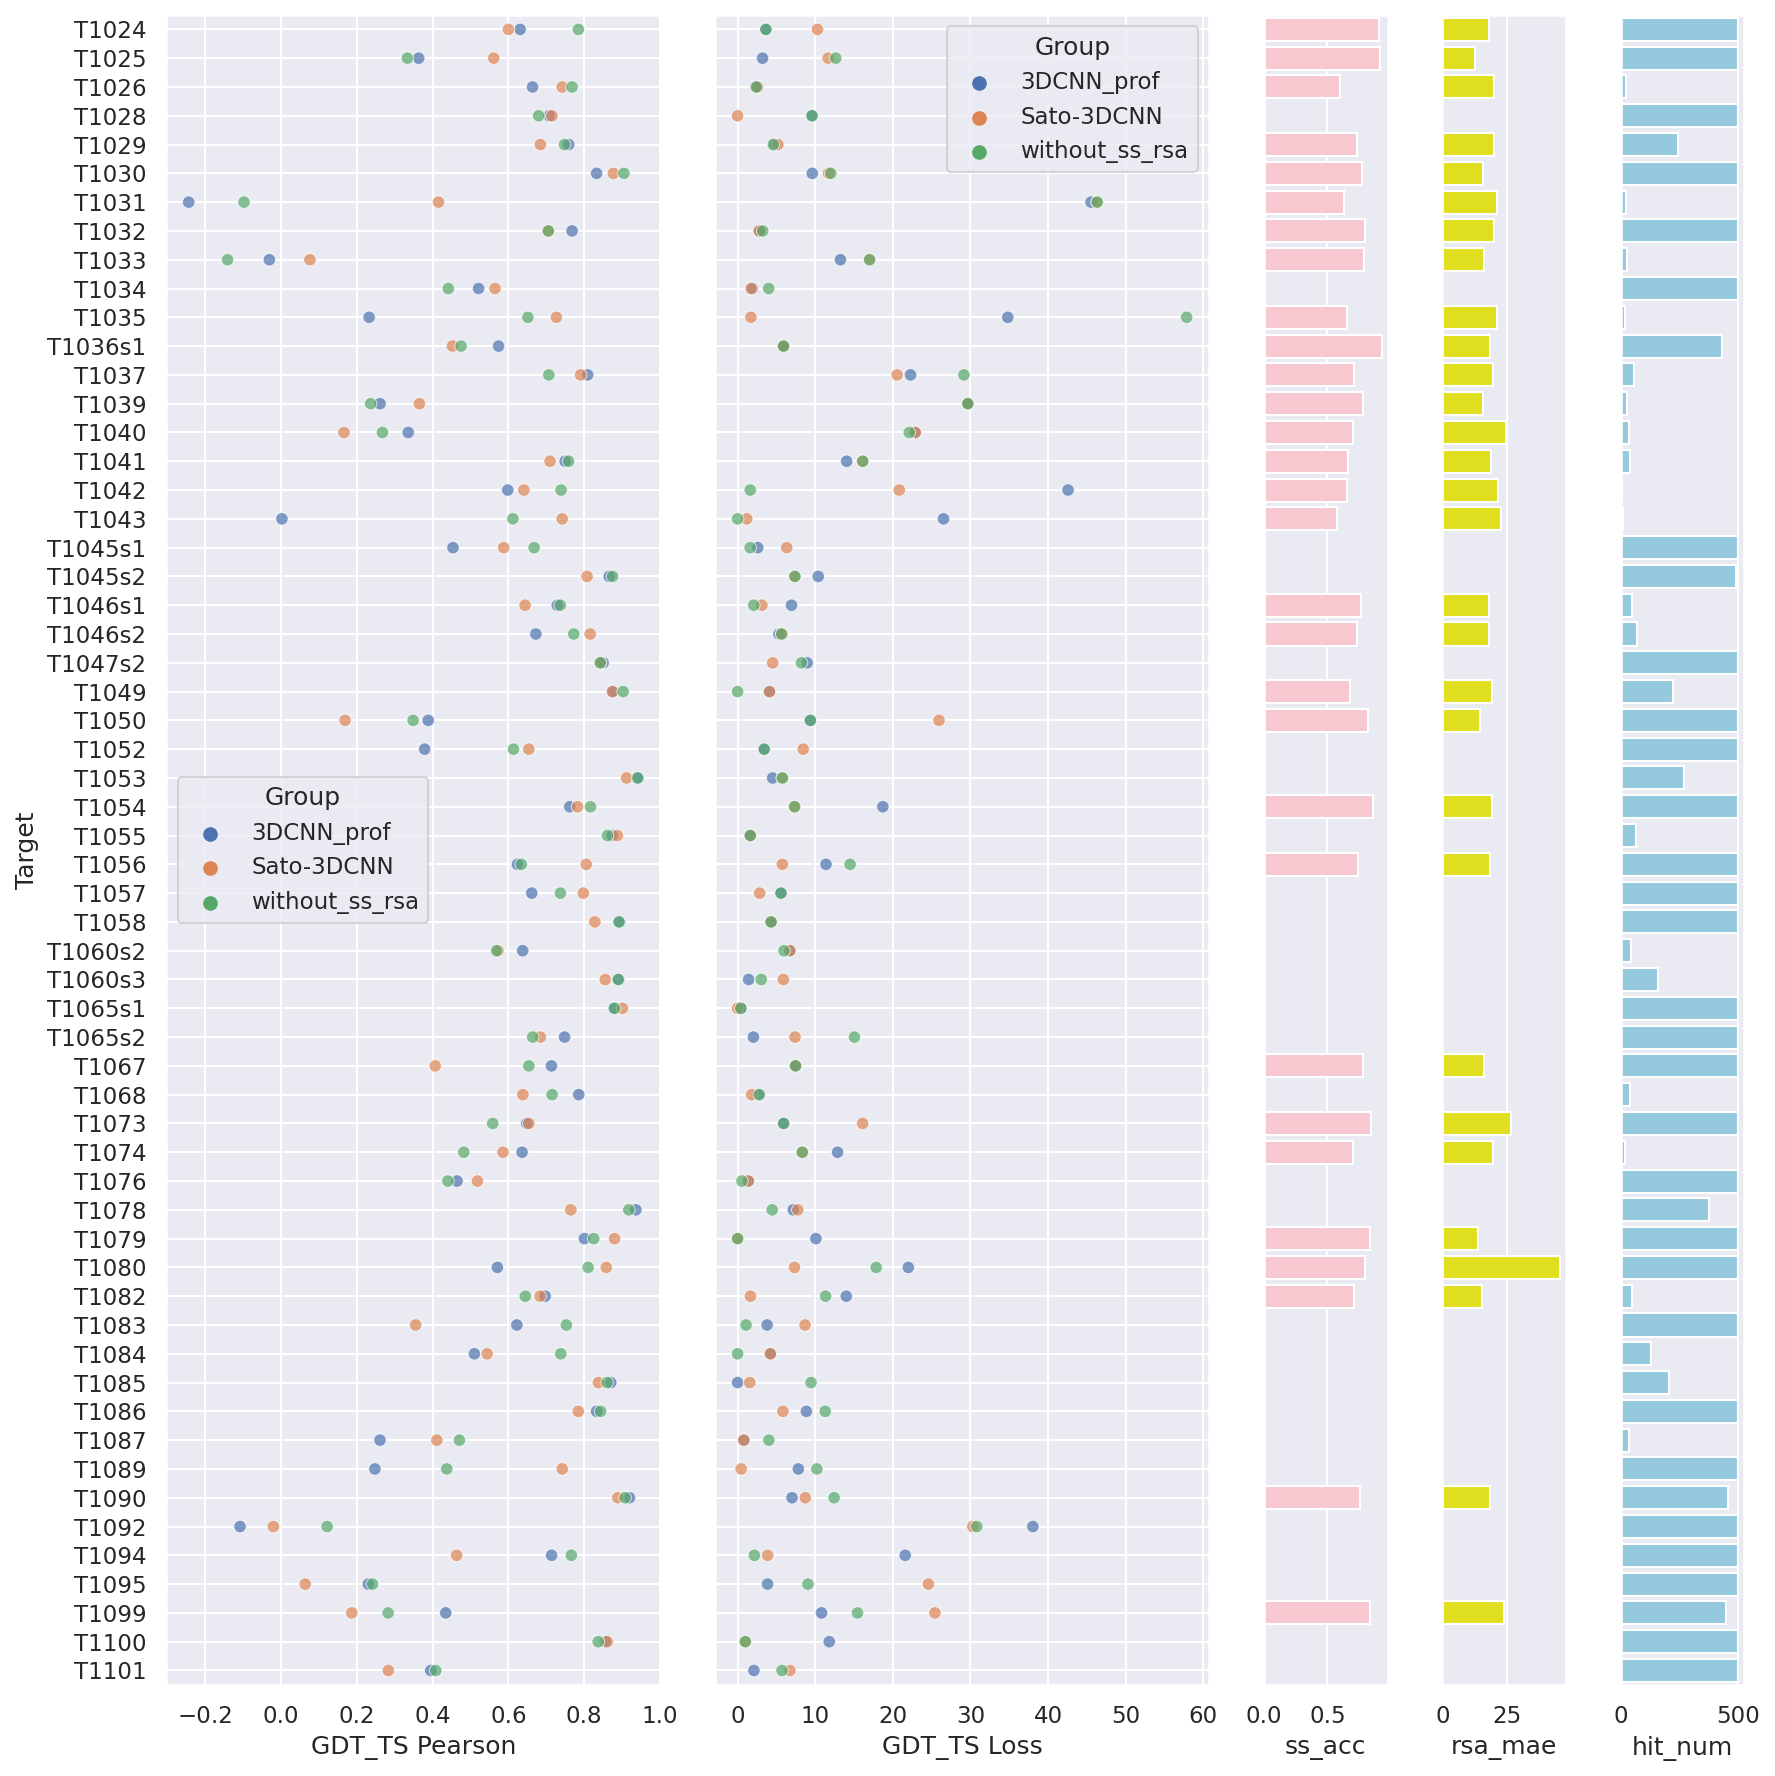

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=False, sharey=True, figsize=(12,12), gridspec_kw={'width_ratios':[2,2,0.5,0.5,0.5]})
alpha=0.7
sns.scatterplot(data=compare_df, x='GDT_TS Pearson', y='Target', hue='Group', ax=axes[0], alpha=alpha)
sns.scatterplot(data=compare_df, x='GDT_TS Loss', y='Target', hue='Group', ax=axes[1], alpha=alpha)
sns.barplot(data=proposed_df, x='ss_acc', y='Target', ax=axes[2], color='pink')
sns.barplot(data=proposed_df, x='rsa_mae', y='Target', ax=axes[3], color='yellow')
sns.barplot(data=proposed_df, x='hit_num', y='Target', ax=axes[4], color='skyblue')
for i in range(2, 5):
    axes[i].yaxis.set_visible(False)
# sns.barplot(data=proposed_df, x='mean_evalue', y='Target', ax=axes[5], color='lightgreen')
plt.tight_layout()
plt.savefig('../data/plot/casp14_proposed_pearson_loss_each_target.png')